## Enunciado

Crie um modelo de image captioning completo similar ao do paper Show, Attend and Tell mas usando a EfficientNet (pré-treinada) como codificador e usando o codificador + decodificador do T5, BART ou Pegasus. Para o decodificador, sugerimos utilizar a biblioteca da Hugginface e adaptar o codificador do Transformers para ter como entrada o feature map extraído da imagem.

Sugerimos ler a página abaixo para se familizarem como a biblioteca implementa a arquitetura encoder-decoder: https://huggingface.co/transformers/model_doc/encoderdecoder.html


Aluno: Gabriel Victor de Sousa Lopes

Link Colab: https://colab.research.google.com/drive/1JGye3Y6BIw6EcsxDbMp3gx4wkPOXWmZ9?usp=sharing

## Track Básica: Usar MS COCO reduzido (23k exemplos de treino)

Download do dataset MS COCO reduzido para 23k exemplos:

In [1]:
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/VAL_IMAGES_coco_5_cap_per_img.hdf5
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_CAPTIONS_coco_5_cap_per_img.json
!wget https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TRAIN_IMAGES_coco_5_cap_per_img.hdf5

--2022-06-22 00:20:49--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_CAPTIONS_coco_5_cap_per_img.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 74.125.203.128, 2404:6800:4008:c15::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289777 (283K) [application/json]
Saving to: ‘TEST_CAPTIONS_coco_5_cap_per_img.json.6’

TEST_CAPTIONS_coco_ 100%[===================>] 282.99K  --.-KB/s    in 0.003s  

2022-06-22 00:20:49 (101 MB/s) - ‘TEST_CAPTIONS_coco_5_cap_per_img.json.6’ saved [289777/289777]

--2022-06-22 00:20:49--  https://storage.googleapis.com/unicamp-dl/ia025a_2022s1/aula10/TEST_IMAGES_coco_5_cap_per_img.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 74.125.203.128, 2404:6800:4008:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connec

In [2]:
# !gsutil -m cp -n gs://neuralresearcher_data/unicamp-dl/ia025a_2022s1/aula10/*_IMAGES_coco_5_cap_per_img.hdf5 .
# !gsutil -m cp -n gs://neuralresearcher_data/unicamp-dl/ia025a_2022s1/aula10/*_CAPTIONS_coco_5_cap_per_img.json .

# Importações Iniciais

In [3]:
! pip install sacrebleu pytorch-lightning transformers efficientnet-pytorch --quiet

In [4]:
# Importar todos os pacotes de uma só vez para evitar duplicados ao longo do notebook.
import gzip
import os
import pytorch_lightning as pl
import random
import sacrebleu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import json

from google.colab import drive

from pytorch_lightning.callbacks import ModelCheckpoint

from efficientnet_pytorch import EfficientNet

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from matplotlib import pyplot as plt
import h5py

In [5]:
# Important: Fix seeds so we can replicate results
seed = 42
random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [6]:
!nvidia-smi

Wed Jun 22 00:21:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset

In [8]:
# %pip install sentencepiece
tokenizer = T5Tokenizer.from_pretrained("t5-small",model_max_length=512)

In [9]:
# Normalização sugerida pelo EffficientNet para realizar o treinamento com exemplos adversarios.
# https://github.com/lukemelas/EfficientNet-PyTorch#update-january-23-2020
transform = transforms.Compose([
    transforms.Lambda(lambda img: img * 2.0  - 1.0),
])


class CaptioningDataset(Dataset):
    """
    Dataset that loads image instances lazily to memory.
    """

    def __init__(self, img_file, target_file, img_transform=lambda x: x, text_transform=lambda x: x):
        
        self.img_file = img_file
        self.images = None
        
        self.targets = json.load(open(target_file, "r"))

        self.img_transform = img_transform
        self.text_transform = text_transform

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
    
        if not self.images:
            self.images = h5py.File(self.img_file, 'r') 
            
        img = self.images["images"][idx]
        cap = self.targets[idx]

        img = img.astype(float)

        # Realiza a normalizaçãop da imagen entre 0 e 1
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
                
        return self.img_transform(img), self.text_transform(cap)

    def __del__(self):
        if self.images:
            self.images.close()
    

In [10]:
'''
A função collate_any seleciona um label aleatório dentre os 5 correspondentes a figura,
e uma vez definido o label realiza-ra o tokenização do mesmo de ocordo com o encoded de
T5. Sendo este usado no Dataset de treino
'''

def collate_any(batch):
   
    imgs = torch.tensor(np.array([r[0] for r in batch]), dtype=torch.float)
    labels = [random.choice(sample[1]) for sample in batch]
    
    batch_tokens = tokenizer.batch_encode_plus(
        labels,
        padding='max_length',
        truncation=True,
        max_length=params['seq_len'], 
        return_tensors="pt")['input_ids']

    return imgs, labels, batch_tokens

'''
 Um processo semelhante é aplicado pela collate_all, entretanto neste usa-se
 os 5 labels de cada imagem, passando eles pelo tokenizador. Sendo este metodo
 usado para os datasets de validação e teste.
'''
def collate_all(batch):
  
    imgs = torch.tensor(np.array([sample[0] for sample in batch]), dtype=torch.float)
    labels = [sample[1] for sample in batch]

    encoded = [tokenizer.batch_encode_plus(label, 
                                           padding='max_length', 
                                           truncation=True,
                                           max_length=params['seq_len'],
                                           return_tensors='pt')['input_ids']
    for label in labels]
            
    return imgs, labels, encoded

In [11]:
train_ds, val_ds, test_ds = [CaptioningDataset(
    img_file=f'{s}_IMAGES_coco_5_cap_per_img.hdf5',
    target_file=f'{s}_CAPTIONS_coco_5_cap_per_img.json',
    img_transform=transform) 
for s in ['TRAIN', 'VAL', 'TEST']
]

# Criando Dataloaders para teste de alinhamento

Para isto são definidos a seguir Dataloaders de validação e treino, como os parâmetros abaixo. 

In [12]:
params = {
    'batch_size_train': 4,
    'num_workers': 1,
    'seq_len': 64
}

In [13]:


train_loader = DataLoader(train_ds,
                          batch_size=params['batch_size_train'],
                          num_workers=params['num_workers'],
                          collate_fn=collate_any)

val_loader = DataLoader(val_ds,
                        batch_size=params['batch_size_train'],
                        num_workers=params['num_workers'],
                        collate_fn=collate_all)

# Avaliando o DataLoader Validação

Primeiramente será avaliado o Dataloader de validação gerado, onde este apresenta 5 Labels para cada uma das imagens conforme indicado a seguir:

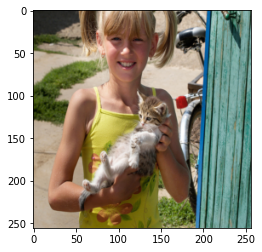

Girl in a tank top holding a kitten in her back yard
A young girl is holding a small cat.
A girl smiles as she holds a kitty cat.
Girl with a yellow shirt holding a small cat
A little girl holding a kitten next to a blue fence.


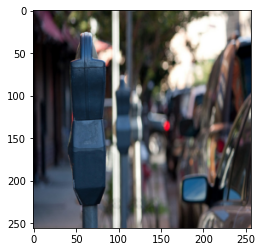

A row of cars parked on a street with parking meters.
A parking meter on a street by a car with traffic.
A series of parking meters and cars are located next to each other. 
A row of parked cars sitting next to parking meters.
A parking meter on a street with cars


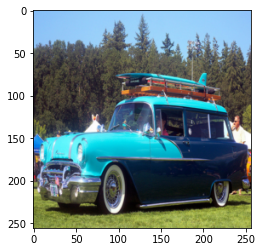

An old station wagon with a surfboard on top of it.
An old car with surfboards on the top.
An old vehicle painted light blue and dark blue.
A car with some surfboards in a field.
The old fashioned car is carrying some retro surfboards.


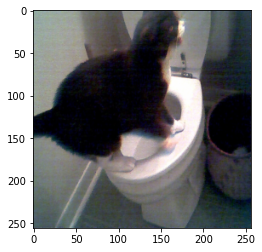

A cat standing on the toilet bowl seat
A cat standing on a toilet with an open lid.
A blurry picture of a cat standing on a toilet.
A cat is perched on the top of a toilet seat in the bathroom.
A cat on the lid of a toilet looking perturbed.


In [14]:
# Val loader usa o collate_all e retorna os 5 labels de cada imagem
imgs,labels, tokens = next(iter(val_loader))
for img, label in zip(imgs, labels):
    # Para apresentar as imagens é necessario desfazer a normalização empregada nas imagens
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # adversarial
    plt.show()
    for caption in label:
      print(caption)


# Avaliando o DataLoader Treino

A seguir será avaliado o Dataloader de treino gerado, onde este apresenta apenas 1 Label para cada uma das imagens, sendo ele escolhido de forma aleatória dentre os 5 caracteristicos da imagem.

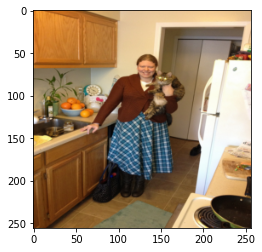

A girl smiles as she holds a cat and wears a brightly colored skirt.


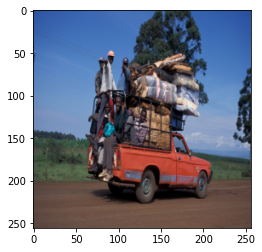

A truck with a number of people and things in the back


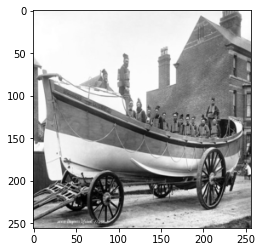

A boat is being rolled on a trailer


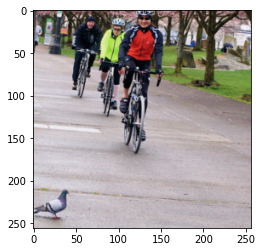

People riding bicycles down the road approaching a bird.


In [15]:
imgs, labels,tokens = next(iter(train_loader))
for img, label in zip(imgs, labels):
    # Desfazendo a normalização da imagem
    plt.imshow((img.numpy().transpose(1, 2, 0)+1)/2) # Normalização da efn adversarial
    plt.show()
    print(label)


# Modelo

Para a construção do modelo, utilizou-se a estrutura basica do Execicio da aula 5, realizado algumas adaptações para a presente aplicação. Adaptações estas baseadas no código de alguns outros alunos da TAg Avançada.

In [16]:
class T5Finetuner(pl.LightningModule):

    def __init__(self, train_dataloader, val_dataloader, test_dataloader, params):
        super(T5Finetuner, self).__init__()

        self.params = params
        
        self._train_dataloader = train_dataloader
        self._val_dataloader   = val_dataloader
        self._test_dataloader  = test_dataloader

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained('efficientnet-b0', advprop=params['advprop'])
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['model_name'])

        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Pra converter a saída da efn para o decoder do t5
        self.bridge = nn.Conv2d(in_channels=1280, out_channels=self.decoder.config.d_model, kernel_size=1)

        self.tokenizer = T5Tokenizer.from_pretrained(params['model_name'])
        self.learning_rate = params['learning_rate']

    def _embeds_forward(self, img):

        # Shape: (N, 1280, 8, 8)
        #Extrai a camada Densa do encoder do efficientNet pre-treinado
        features = self.encoder.extract_features(img)

        # Shape: (N, 512, 8, 8)
        features = self.bridge(features)

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 2, 3, 1) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return efn_embeddings

    def forward(self, batch):

        images, labels, tokens = batch

        # # Shape: (N, 1280, 8, 8)
        # #Extrai a camada Densa do encoder do efficientNet pre-treinado
        # features = self.encoder.extract_features(images)

        # # Shape: (N, 512, 8, 8)
        # features = self.bridge(features)

        # # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        # efn_embeddings = features \
        #     .permute(0, 2, 3, 1) \
        #     .reshape(features.shape[0], -1, self.decoder.config.d_model)

        efn_embeddings = self._embeds_forward(images)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=tokens,
                                   return_dict=True)
            return outputs.loss
        else:
            max_length = self.params['seq_len']

            # Add start of sequence token
            decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                    self.decoder.config.decoder_start_token_id,
                                    dtype=torch.long).to(efn_embeddings.device)


            encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

            for step in range(max_length-1):
                logits = self.decoder(decoder_input_ids=decoded_ids,
                                      encoder_outputs=encoder_hidden_states)[0]
                next_token_logits = logits[:, -1, :]

                # Greedy decoding
                next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
                
                # Check if output is end of senquence for all batches
                if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                    break

                # Concatenate past ids with new id, keeping batch dimension
                decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

            return decoded_ids
    def generate(self, img, max_len=32):

      # We need to implement our own generate loop as transformers doesn't accept 
      # precomputed embeddings on the generate method.
      # Issue: https://github.com/huggingface/transformers/issues/7626

      # Precompute embeddings to speedup generation as they don't change.
      efn_embeddings = self._embeds_forward(img)
      

      max_length = max_len

      # Add start of sequence token
      decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                              self.decoder.config.decoder_start_token_id,
                              dtype=torch.long).to(efn_embeddings.device)


      encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

      for step in range(max_length-1):
          logits = self.decoder(decoder_input_ids=decoded_ids,
                                encoder_outputs=encoder_hidden_states)[0]
          next_token_logits = logits[:, -1, :]

          # Greedy decoding
          next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
          
          # Check if output is end of senquence for all batches
          if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
              break

          # Concatenate past ids with new id, keeping batch dimension
          decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

      # decoder_input_ids = torch.full(
      #     (1, 1), self.decoder.config.decoder_start_token_id, dtype=torch.long
      # ).to(inputs_embeds.device)
      # # decoder_input_ids = torch.full((inputs_embeds.shape[0], 1),
      # #                               self.decoder.config.decoder_start_token_id,
      # #                               dtype=torch.long).to(inputs_embeds.device)
      # print(decoder_input_ids)

      # for i in range(max_len):
      #     with torch.no_grad():
      #         output =  self.decoder(
      #                         inputs_embeds=inputs_embeds,
      #                         decoder_input_ids=decoder_input_ids, 
      #                         labels=labels,
      #                     )
      #     print(output)
      #     logits = output[0]
      #     next_token_logits = logits[:, -1, :]
      #     next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
      #     decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1).to(img.device)

      #     if torch.eq(next_token_id[:, -1], self.decoder.config.eos_token_id).all():
      #         break

      return decoded_ids

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        return {"pred": decoded_pred, "target": batch[1]}

    def validation_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        # Sobre como o corpus_bleu interpreta os inputs: 
        # https://github.com/mjpost/sacreBLEU/issues/28
        bleu = sacrebleu.corpus_bleu(preds, list(zip(*trues)))
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)

        self.log("val_bleu_score", bleu.score, prog_bar=True)

    def test_epoch_end(self, outputs):
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        # Sobre como o corpus_bleu interpreta os inputs: 
        # https://github.com/mjpost/sacreBLEU/issues/28
        bleu = sacrebleu.corpus_bleu(preds, list(zip(*trues)))

        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(
            [p for p in self.parameters() if p.requires_grad],
            lr=self.learning_rate, eps=1e-08)

    def train_dataloader(self):
        return self._train_dataloader

    def val_dataloader(self):
        return self._val_dataloader

    def test_dataloader(self):
        return self._test_dataloader

In [17]:
lr =  1e-4#@param {type: "number"}
bs =    64#@param {type: "integer"} 
seq_len = 20 #@param {type: "integer"}
patience =  5#@param {type: "integer"}
max_epochs =  1#@param {type: "integer"}
num_workers =  4#@param {type: "integer"}

# Define hyperparameters
params = {
          
          'model_name': 't5-small',
          'model_max_length': 512,
          'advprop': True,
          'batch_size': bs,
          'num_workers': num_workers,
          'seq_len': seq_len,
          'learning_rate': lr,
          'max_epochs': max_epochs, 
          'patience': patience,
          'monitor_variable': 'val_bleu_score'
      }
print(params)

{'model_name': 't5-small', 'model_max_length': 512, 'advprop': True, 'batch_size': 64, 'num_workers': 4, 'seq_len': 20, 'learning_rate': 0.0001, 'max_epochs': 1, 'patience': 5, 'monitor_variable': 'val_bleu_score'}


# Definindo os Dataloaders 

In [18]:
train_loader = DataLoader(train_ds,
                          batch_size=params['batch_size'],
                          num_workers=params['num_workers'],
                          collate_fn=collate_any)

val_loader = DataLoader(val_ds,
                        batch_size=params['batch_size'],
                        num_workers=params['num_workers'],
                        collate_fn=collate_all)

test_loader = DataLoader(test_ds,
                         batch_size=params['batch_size'],
                         num_workers=params['num_workers'],
                         collate_fn=collate_all)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)

Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [20]:
sum([torch.tensor(x.size()).prod() for x in model.parameters() if x.requires_grad]) # trainable parameters

tensor(61162496)

# Teste do modelo com 1 batch

In [21]:
trainer = pl.Trainer(gpus=1, 
                     max_epochs=1,
                     enable_checkpointing=False,  # Disable checkpoint saving.
                     fast_dev_run=True)

trainer.fit(model)
trainer.test(model)
del model  # Para não ter estouro de mémoria da GPU

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | Conv2d                     | 655 K 
----------------------------------------------

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]


Sample Target: ['A cat sitting on top of a stuffed animal. ', 'a cat lays down on a stuffed animal', 'A cat sitting in a chair that looks like an elephant', 'a fat cat sits on a stuffed animal', 'A spoiled cat is sitting on his own personal chair.']
Prediction: <pad>



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Sample Target: ['A couple of people sitting on a bench next to a dog.', 'A dog sitting on a bench next to an old man.', 'A large white dog sits on a bench with people next to a path.', 'A large dog sits just his bottom on a park bench.', 'A large white dog is sitting on a bench beside an elderly man.']
Prediction: <pad>

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           2.281879186630249
       test_bleu_4         0.022603977471590042
     test_bleu_score        0.11129837483167648
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Treino completo

In [22]:
checkpoint_path = '/content/drive/MyDrive/Gabriel/epoch{epoch}-{val_bleu_score:.2f}.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))

print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')

# Log results to CSV (so we can plot them later).
logger = pl.loggers.csv_logs.CSVLogger(f"/content/drive/MyDrive/Gabriel/logs", name="captioning")

# Early stop if val BLEU score doesnt increase for 10 epochs.
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_bleu_score', patience=10, mode='max')

# Checkpoint the best model.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="/content/drive/MyDrive/Gabriel/logs/{epoch}-{val_bleu_score:.2f}", 
    monitor="val_bleu_score", 
    mode="max",
)


trainer = pl.Trainer(gpus=1,
                     max_epochs=params['max_epochs'],
                     check_val_every_n_epoch=1,
                    #  profiler='simple',
                     logger=logger, 
                     callbacks=[early_stop_callback],
                     checkpoint_callback=checkpoint_callback,
                     progress_bar_refresh_rate=50)

model = T5Finetuner(train_dataloader=train_loader,
                    val_dataloader=val_loader,
                    test_dataloader=test_loader,
                    params=params)

trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f0e0f69a7d0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f0e0f69a7d0>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=50)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

Files in /content/drive/MyDrive/Gabriel: ['logs']
Saving checkpoints to /content/drive/MyDrive/Gabriel
Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Sample Target: ['A horse and cows graze in a grassy field on a cloudy day', 'A horse walking through a grassy field while two cows eat hay. ', 'one black horse and two cows in a field', 'A couple of cows and horse standing in green field', 'A lone horse and two cows in a beautiful green field on a dreary day.']
Prediction: <pad>



Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validation: 0it [00:00, ?it/s]


Sample Target: ['A black cat pawing at a open cup.', 'A black and white cat reaching for a cup.', 'A cat drinking milk from a cup on a nightstand.', 'A cat drinking water out of a white cup.', 'A black cat taking a drink out of a white cup.']
Prediction: <pad> A cat sitting on a table in a chair.</s> <pad> <pad> <pad> <pad> <pad> <pad>



In [23]:
trainer.test(model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Sample Target: ['two orange gray and black birds sitting in a tree', 'a close up of two small birds in a tree branch', 'Orange and black songbirds perched in a frozen appletree.', 'Two birds perched on limbs next to berries.', 'Two birds sit on snow covered branches next to small, green fruits.']
Prediction: <pad> A cat is sitting on a table next to a table.</s> <pad> <pad> <pad> <pad>

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           18.10724639892578
       test_bleu_4          0.26786568760871887
     test_bleu_score         2.21592116355896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 18.10724639892578,
  'test_bleu_4': 0.26786568760871887,
  'test_bleu_score': 2.21592116355896}]

# Resultado de algumas imagens

In [24]:
test_loader = DataLoader(test_ds,
                         batch_size=32,
                         num_workers=params['num_workers'],
                         collate_fn=collate_all)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
model = model.load_from_checkpoint("/content/drive/MyDrive/Gabriel/logs/captioning/version_2/checkpoints/epoch=29-step=11040.ckpt",
                                   train_dataloader=train_loader,
                                   val_dataloader=val_loader,
                                   test_dataloader=test_loader,
                                   params=params)

FileNotFoundError: ignored

In [26]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Sample Target: ['Shot of a bathroom with a toilet in the center of the image and cat cage next to it.', 'This is a bathroom that is in someones home. ', 'A small bathroom has a toilet and litter box.', 'A door leading to a bathroom with a litter box in it', 'A bathroom with a toilet that has a purse and pet cage sitting next to it.']
Prediction: <pad> A man is laying on a tree in a tree.</s> <pad> <pad> <pad> <pad>

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_bleu_1           18.10724639892578
       test_bleu_4          0.26786568760871887
     test_bleu_score         2.21592116355896
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_bleu_1': 18.10724639892578,
  'test_bleu_4': 0.26786568760871887,
  'test_bleu_score': 2.21592116355896}]

In [ ]:
batch = next(iter(test_loader))

images, labels, tokens = batch

model.eval()
model.cpu()

pred_tokens = model(batch)

decoded_preds = [model.tokenizer.decode(t) for t in pred_tokens]

for image, label, pred in zip(images, labels, decoded_preds):
    plt.imshow((image.squeeze(0).numpy().transpose(1, 2, 0)+1) / 2)
    plt.show()
    print(f'Labels: {label}\nPred: {pred}\n')

In [ ]:
from matplotlib import pyplot as plt
import cv2


val_loader = DataLoader(val_ds, batch_size=1, collate_fn=collate_all)
results = []


for batch, i in zip(val_loader, range(32)):
        
    imgs, _, refs = batch

    for (img, ref) in zip(imgs, refs):
        norm_img = (img.numpy() + 1) / 2.
        
        attention_weights = {}
  
        tokens = model.generate(img.view((1,) + img.shape))[0]
        weights = list(zip(*attention_weights.values()))

        
        
        results.append((norm_img, tokens, weights))

In [ ]:
from matplotlib import pyplot as plt
import cv2


for img, tokens, weights in results[:1]:
    print(weights)
    print(tokens)
    # for head in range(8):

    #     f, axes = plt.subplots(1, len(weights) - 1, figsize=(50, 5))

    #     for token, weight, ax in zip(tokens.tolist()[1:-1], weights, range(len(weights))):
    #         weight = torch.cat(weight)  # shape (num_blocks, num_heads, num_tokens, d_model)
    #         max_heads = weight[-1, head, -1, :]
    #         max_heads = max_heads / max_heads.max()

    #         expanded_attention = cv2.resize(max_heads.view(16, 16).numpy(), dsize=(256, 256), interpolation=cv2.INTER_LINEAR)

    #         axes[ax].imshow(
    #             np.moveaxis(expanded_attention * img, 0, 2)
    #         )
    #         axes[ax].set_title(tokenizer.decode(token))
    #         axes[ax].axis(False)

    #     plt.show()